# Modelos alternativos - CNNs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/datasets/bargal/dataset.processed.GRLogDiff.zip' -d './data/processed' -qq

In [ ]:
# Uncomment this if running in Google Colab. It will install the bargal package from GitHub.
!pip install git+https://github.com/ludanortmun/itesm-mna-barred-galaxies.git -q

In [95]:
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, \
    precision_score
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image

from bargal.dataset.load import load_dataset

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# Preparando el conjunto de datos

El primer paso consiste en cargar nuestro conjunto de datos y dividirlo en conjunto de entrenamiento, validación y prueba.

In [97]:
dataset_path = './data/dataset.csv'

df = load_dataset(dataset_path)

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Bars'])
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Bars'])

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(valid_df)}')
print(f'Test size: {len(test_df)}')

Train size: 7088
Validation size: 1519
Test size: 1519


Ahora creamos nuestra clase para representar el conjunto de datos, heredando de Dataset de PyTorch. El dataset a utilizar para nuestra red neuronal consiste en imágenes de galaxias y su respectiva etiqueta, que indica si la galaxia tiene o no una barra.

La etiqueta es un tensor de tamaño 1, donde 1 indica que la galaxia tiene una barra y 0 indica que no. Sin embargo, el conjunto de datos original no tiene etiquetas binarias, sino múltiples categorías indicando el tipo de barra que tiene la galaxia. Por lo tanto, convertimos cualquier etiqueta que represente la presencia de una barra (independientemente de sus características) a 1 y cualquier etiqueta que represente la ausencia de una barra a 0. También debemos filtrar elementos con la etiqueta -0.5, la cual simboliza que la categoria de la galaxia es desconocida. Estas transformaciones fueron exploradas previamente en el entregable [Avance1.Equipo22.ipynb](https://github.com/ludanortmun/itesm-mna-barred-galaxies/tree/main/notebooks/Avance1.Equipo22.ipynb), donde se creó la columna `has_bar` derivada de `Bars` y se filtraron los elementos sin clasificación.

En cuanto a la carga de imágenes, este conjunto de datos consiste en las imágenes de galaxias sin procesamiento, en formato JPG a color. El preprocesamiento consiste, principalmente, en la sustracción de las bandas G y R para enfatizar las estructuras de barras. Las imágenes resultantes tienen dimensiones de 400x400 píxeles y están en escala de grises. Sin embargo, debido a que esta red neuronal espera imágenes con 3 canales de entrada, la imagen es convertida a representación RGB. Estas imágenes son cargadas utilizando la librería PIL y convertidas a tensores.

El script de preprocesamiento puede ser consultado en este enlace: [bargal/commands/preprocess.py](https://github.com/ludanortmun/itesm-mna-barred-galaxies/blob/297f69b278ea6bc5099ef23a0d539602995bc55e/bargal/commands/preprocess.py)

El conjunto de imágenes pre procesadas puede descargarse con el siguiente enlace: [dataset.processed.GRLogDiff](https://tecmx-my.sharepoint.com/:u:/g/personal/a01795197_tec_mx/EexaLnqaLLdCt1JNxLib8VYBeOHJo95vuOr-Pfxv-55Iww?e=0gfeuq)


In [98]:
class GalaxiesDataset(Dataset):
    def __init__(self, galaxies_df: pd.DataFrame, img_dir: str):
        self.filtered_df = galaxies_df[galaxies_df['Bars'] >= 0].reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.filtered_df)

    def __getitem__(self, idx):
        row = self.filtered_df.iloc[idx]
        label = 1.0 if row['Bars'] != 0 else 0.0
        img_path = f"{self.img_dir}/{row['name']}.png"

        # Load image and convert to tensor
        with Image.open(img_path) as img:
            # Convert grayscale to RGB
            image = transforms.ToTensor()(img.convert('RGB'))

        return image.to(device), torch.tensor([label], dtype=torch.float32).to(device)

In [99]:
n = 32
processed_images_path = './data/processed'

train_data = GalaxiesDataset(train_df, processed_images_path)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = GalaxiesDataset(valid_df, processed_images_path)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

test_data = GalaxiesDataset(test_df, processed_images_path)
test_loader = DataLoader(test_data, batch_size=n)
test_N = len(test_loader.dataset)

# Modelo 1: MobileNetV3

## Definiendo el modelo

### Modelo pre-entrenado base

Para este modelo, se utilizará la arquitectura MobileNet V3 en su variante Large pre-entrenada con el conjunto de datos de ImageNet.

In [100]:
from torchvision.models.mobilenet import mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights

weights = MobileNet_V3_Large_Weights.DEFAULT
mobilenet_base_model = mobilenet_v3_large(weights=weights)

In [101]:
mobilenet_base_model.to(device)
mobilenet_base_model.requires_grad_(False)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Adaptando el modelo

Agregamos una capa lineal al final de la red neuronal. Esta capa sólo tiene 1 neurona de salida, puesto que estamos trabajando con un problema de clasificación binaria.

In [102]:
model_mobilenet = nn.Sequential(
    mobilenet_base_model,
    nn.Linear(1000, 1)
)

### Preparando función de pérdida y optimizador

Debido a que estamos trabajando con un problema de clasificación binaria, utilizaremos la función de pérdida BCEWithLogitsLoss. El optimizador a utilizar es Adam.

Debido a que nuestro problema es no balanceado y además nos interesa optimizar la métrica de recall, podemos configurar el argumento `pos_weight` de la función de pérdida para darle mayor peso a la clase positiva. Este argumento lo calculamos diviendo la cantidad de elementos de la clase negativa entre la cantidad de elementos de la clase positiva, lo cual deberá resultar en un valor mayor a 1.

In [103]:
pos_weight = train_data.filtered_df['Bars'][train_data.filtered_df['Bars'] == 0].count() / train_data.filtered_df['Bars'][train_data.filtered_df['Bars'] != 0].count()
print(f'Using pos_weight={pos_weight}')

Using pos_weight=1.6551984877126653


In [104]:
mobilenet_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
mobilenet_optimizer = Adam(model_mobilenet.parameters())
model_mobilenet = model_mobilenet.to(device)

## Entrenamiento

### Definiendo funciones de entrenamiento

In [105]:
def get_classification_metrics(y_pred, y_true):
    return {
        'accuracy': accuracy_score(y_true=y_true, y_pred=y_pred),
        'recall': recall_score(y_true=y_true, y_pred=y_pred),
        'f1': f1_score(y_true=y_true, y_pred=y_pred),
        'precision': precision_score(y_true=y_true, y_pred=y_pred),
    }

In [106]:
def train(model, optimizer, loss_fn) -> dict[str, float]:
    loss = 0
    y_pred = []
    y_train = []

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_fn(output, y)
        batch_loss.backward()
        optimizer.step()

        y_train += [int(y[i]) for i in range(len(y))]
        predictions = torch.gt(output, torch.tensor([0]).to(device))
        y_pred += [int(predictions[i]) for i in range(len(y))]

        loss += batch_loss.item()

    return {
        'loss': loss,
        **get_classification_metrics(y_pred, y_train),
    }

In [107]:
def validate(model, loss_fn) -> dict[str, float]:
    loss = 0
    y_pred = []
    y_val = []

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_fn(output, y).item()

            y_val += [int(y[i]) for i in range(len(y))]
            predictions = torch.gt(output, torch.tensor([0]).to(device))
            y_pred += [int(predictions[i]) for i in range(len(y))]

    return {
        'loss': loss,
        **get_classification_metrics(y_pred, y_val),
    }

### Ejecución del entrenamiento

In [108]:
epochs = 10
mobilenet_train_metrics = []
mobilenet_valid_metrics = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    train_metrics = train(model_mobilenet, mobilenet_optimizer, mobilenet_loss_fn)
    print(f"Train accuracy: {train_metrics['accuracy']:.4f} | Train recall: {train_metrics['recall']:.4f} | "
          f"Train precision: {train_metrics['precision']:.4f} | Train F1: {train_metrics['f1']:.4f} | "
          f"Train loss: {train_metrics['loss']:.4f}")
    mobilenet_train_metrics.append(train_metrics)

    valid_metrics = validate(model_mobilenet, mobilenet_loss_fn)
    print(f"Valid accuracy: {valid_metrics['accuracy']:.4f} | Valid recall: {valid_metrics['recall']:.4f} | "
          f"Valid precision: {valid_metrics['precision']:.4f} | Valid F1: {valid_metrics['f1']:.4f} | "
          f"Valid loss: {valid_metrics['loss']:.4f}")
    mobilenet_valid_metrics.append(valid_metrics)

Epoch 0
Train accuracy: 0.6057 | Train recall: 0.6212 | Train precision: 0.4818 | Train F1: 0.5427 | Train loss: 178.9982
Valid accuracy: 0.3920 | Valid recall: 0.9735 | Valid precision: 0.3802 | Valid F1: 0.5468 | Valid loss: 43.0632
Epoch 1
Train accuracy: 0.6445 | Train recall: 0.6465 | Train precision: 0.5226 | Train F1: 0.5780 | Train loss: 172.8289
Valid accuracy: 0.4864 | Valid recall: 0.8660 | Valid precision: 0.4133 | Valid F1: 0.5595 | Valid loss: 41.1457
Epoch 2
Train accuracy: 0.6573 | Train recall: 0.6692 | Train precision: 0.5360 | Train F1: 0.5953 | Train loss: 170.5515
Valid accuracy: 0.6691 | Valid recall: 0.5908 | Valid precision: 0.5574 | Valid F1: 0.5736 | Valid loss: 38.0630
Epoch 3
Train accuracy: 0.6641 | Train recall: 0.6809 | Train precision: 0.5431 | Train F1: 0.6043 | Train loss: 168.6218
Valid accuracy: 0.6651 | Valid recall: 0.5785 | Valid precision: 0.5531 | Valid F1: 0.5655 | Valid loss: 38.2072
Epoch 4
Train accuracy: 0.6687 | Train recall: 0.6752 | Trai

## Fine-Tunning

El entrenamiento realizado sólamente actualizó la última capa agregada para realizar la clasificación binaria. Sin embargo, podemos realizar fine-tunning para mejorar aún más el rendimiento de nuestro modelo. Para esto, "descongelamos" el modelo base y repetimos el entrenamiento.

In [109]:
mobilenet_base_model.requires_grad_(True)
mobilenet_optimizer = Adam(model_mobilenet.parameters(), lr=0.000001)

In [110]:
epochs = 4

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    train_metrics = train(model_mobilenet, mobilenet_optimizer, mobilenet_loss_fn)
    print(f"Train accuracy: {train_metrics['accuracy']:.4f} | Train recall: {train_metrics['recall']:.4f} | "
          f"Train precision: {train_metrics['precision']:.4f} | Train F1: {train_metrics['f1']:.4f} | "
          f"Train loss: {train_metrics['loss']:.4f}")
    mobilenet_train_metrics.append(train_metrics)

    valid_metrics = validate(model_mobilenet, mobilenet_loss_fn)
    print(f"Valid accuracy: {valid_metrics['accuracy']:.4f} | Valid recall: {valid_metrics['recall']:.4f} | "
          f"Valid precision: {valid_metrics['precision']:.4f} | Valid F1: {valid_metrics['f1']:.4f} | "
          f"Valid loss: {valid_metrics['loss']:.4f}")
    mobilenet_valid_metrics.append(valid_metrics)

Epoch 0
Train accuracy: 0.6856 | Train recall: 0.6911 | Train precision: 0.5679 | Train F1: 0.6235 | Train loss: 162.3646
Valid accuracy: 0.6625 | Valid recall: 0.6631 | Valid precision: 0.5426 | Valid F1: 0.5968 | Valid loss: 37.4547
Epoch 1
Train accuracy: 0.6924 | Train recall: 0.6994 | Train precision: 0.5754 | Train F1: 0.6314 | Train loss: 161.3011
Valid accuracy: 0.6651 | Valid recall: 0.6667 | Valid precision: 0.5455 | Valid F1: 0.6000 | Valid loss: 37.1365
Epoch 2
Train accuracy: 0.7018 | Train recall: 0.7134 | Train precision: 0.5855 | Train F1: 0.6431 | Train loss: 158.9396
Valid accuracy: 0.6724 | Valid recall: 0.6772 | Valid precision: 0.5533 | Valid F1: 0.6090 | Valid loss: 36.8964
Epoch 3
Train accuracy: 0.7041 | Train recall: 0.6979 | Train precision: 0.5907 | Train F1: 0.6399 | Train loss: 157.9019
Valid accuracy: 0.6704 | Valid recall: 0.6843 | Valid precision: 0.5504 | Valid F1: 0.6101 | Valid loss: 36.7580


## Evaluación


In [111]:
model_mobilenet.requires_grad_(False)
model_mobilenet.eval()

Sequential(
  (0): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
    

In [112]:
y_test = []
y_pred = []

for x, y in test_loader:
    y_test += [int(y[i]) for i in range(len(y))]

    output = model_mobilenet(x)
    predictions = torch.gt(output, torch.tensor([0]).to(device))
    y_pred += [int(predictions[i]) for i in range(len(y))]

In [113]:
mobilenet_test_metrics = get_classification_metrics(y_pred, y_test)

print(f"Train accuracy: {mobilenet_test_metrics['accuracy']:.4f}")
print(f"Train recall: {mobilenet_test_metrics['recall']:.4f}")
print(f"Train precision: {mobilenet_test_metrics['precision']:.4f}")
print(f"Train F1: {mobilenet_test_metrics['f1']:.4f}")

Train accuracy: 0.6797
Train recall: 0.7319
Train precision: 0.5570
Train F1: 0.6326


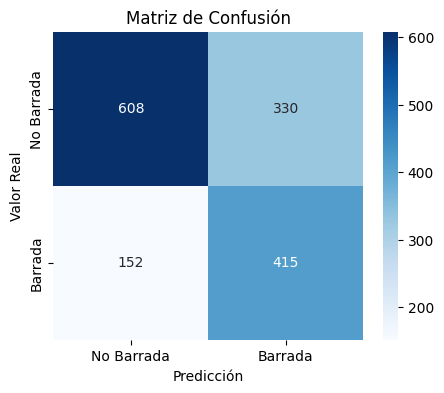

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Barrada", "Barrada"], yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [115]:
print("Reporte de Clasificación")
print(classification_report(y_test, y_pred, target_names=["No Barrada", "Barrada"]))

Reporte de Clasificación
              precision    recall  f1-score   support

  No Barrada       0.80      0.65      0.72       938
     Barrada       0.56      0.73      0.63       567

    accuracy                           0.68      1505
   macro avg       0.68      0.69      0.67      1505
weighted avg       0.71      0.68      0.68      1505



In [116]:
def plot_metrics_comparison(train_metrics, valid_metrics, test_metrics):
    metrics = ['accuracy', 'recall', 'precision', 'f1']
    sets = ['Train', 'Validation', 'Test']

    # Set up the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Model Performance Metrics Comparison')

    # Get metrics values
    values = {
        'Train': train_metrics,
        'Validation': valid_metrics,
        'Test': test_metrics
    }

    # Plot each metric
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        x = np.arange(len(sets))
        metric_values = [values[s][metric] for s in sets]

        ax.bar(x, metric_values)
        ax.set_title(metric.capitalize())
        ax.set_xticks(x)
        ax.set_xticklabels(sets)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)

        # Add value labels on top of bars
        for i, v in enumerate(metric_values):
            ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

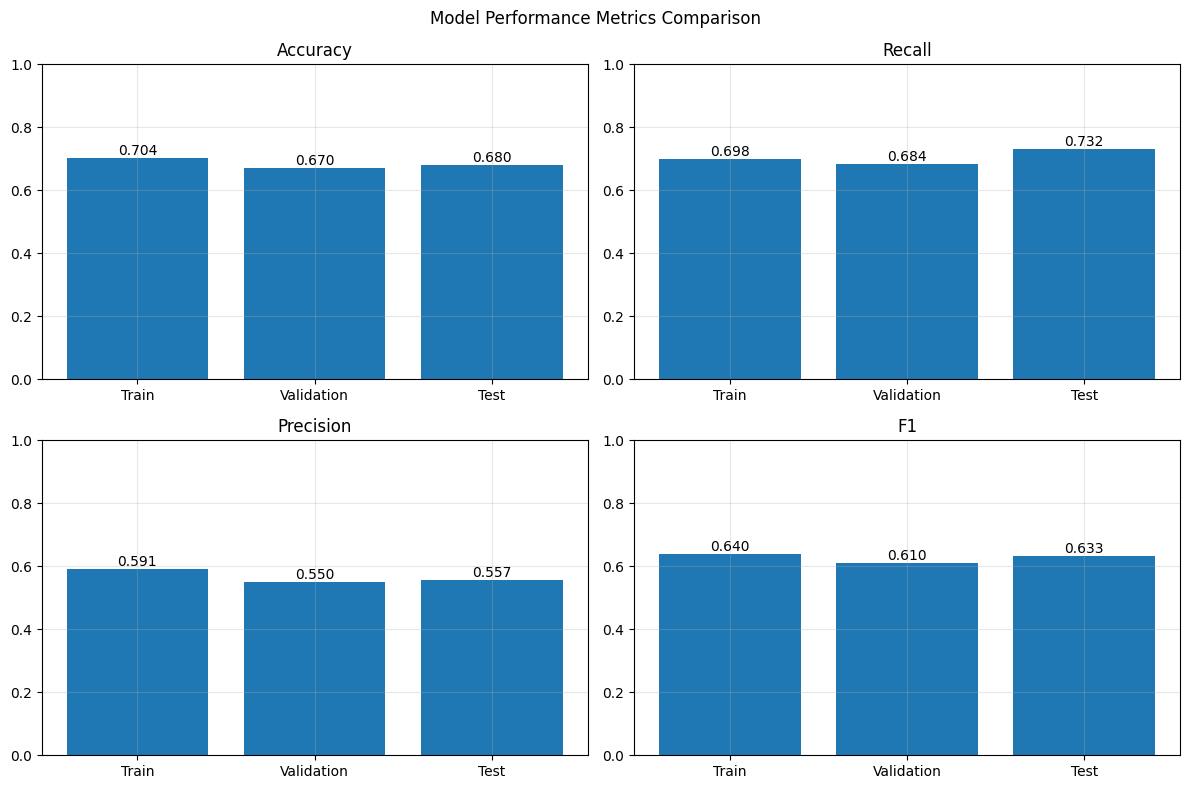

In [117]:
plot_metrics_comparison(mobilenet_train_metrics[-1], mobilenet_valid_metrics[-1], mobilenet_test_metrics)

In [118]:
def plot_learning_curves(test_metrics, valid_metrics, fine_tune_epochs=2):
    test_loss = [test_metrics[i]['loss'] for i in range(len(test_metrics))]
    valid_loss = [valid_metrics[i]['loss'] for i in range(len(valid_metrics))]

    fig, axs = plt.subplots(1, 2, figsize=(12,4))

    axs[0].plot(test_loss, label='Test Loss')
    axs[0].set_title('Test Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].axvline(x=len(test_metrics) -1 - fine_tune_epochs, color='red', linestyle='--', label='Fine tuning')
    axs[0].legend()

    axs[1].plot(valid_loss, label='Validation Loss')
    axs[1].set_title('Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].axvline(x=len(test_metrics) -1 - fine_tune_epochs, color='red', linestyle='--', label='Fine tuning')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

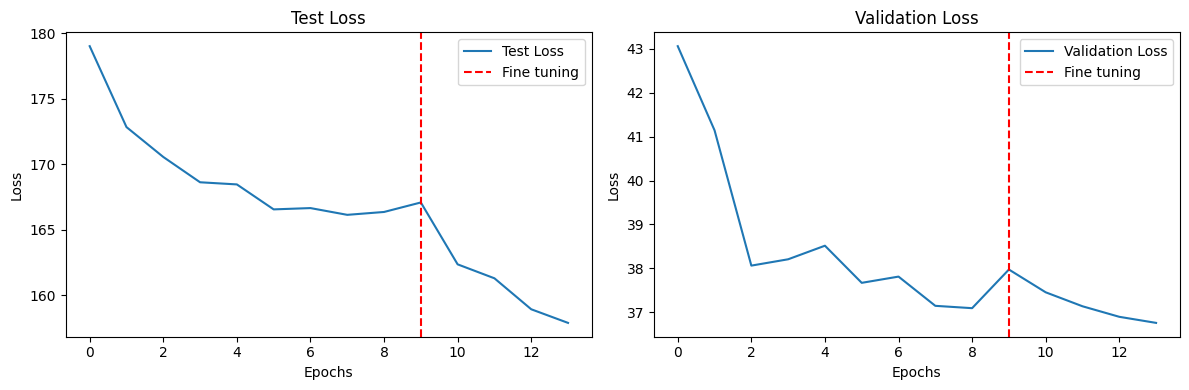

In [119]:
plot_learning_curves(mobilenet_train_metrics, mobilenet_valid_metrics, fine_tune_epochs=4)

## Guardando el modelo

In [120]:
model_path = '/content/drive/MyDrive/datasets/bargal/model_mobile_netv3.pth'
torch.save(model_mobilenet.state_dict(), model_path)

# Modelo 2: EfficientNet

## Definiendo el modelo

### Modelo pre-entrenado base

Para este modelo, se utilizará la arquitectura EfficientNetV2 en su variante S pre-entrenada con el conjunto de datos de ImageNet.

In [121]:
from torchvision.models.efficientnet import efficientnet_v2_s
from torchvision.models import EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.DEFAULT
efficientnet_base_model = efficientnet_v2_s(weights=weights)

In [122]:
efficientnet_base_model.to(device)
efficientnet_base_model.requires_grad_(False)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### Adaptando el modelo

Agregamos una capa lineal al final de la red neuronal. Esta capa sólo tiene 1 neurona de salida, puesto que estamos trabajando con un problema de clasificación binaria.

In [123]:
model_efficientnet = nn.Sequential(
    efficientnet_base_model,
    nn.Linear(1000, 1)
)

### Preparando función de pérdida y optimizador

Debido a que estamos trabajando con un problema de clasificación binaria, utilizaremos la función de pérdida BCEWithLogitsLoss. El optimizador a utilizar es Adam. Nuevamente utilizamos el valor de pos_weight calculado preiamente.

In [124]:
efficientnet_loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
efficientnet_optimizer = Adam(model_efficientnet.parameters())
model_efficientnet = model_efficientnet.to(device)

## Entrenamiento

No es necesario volver a definir nuestras funciones de entrenamiento, por lo que podemos pasar directamente a su ejecución.

In [125]:
epochs = 10
efficientnet_train_metrics = []
efficientnet_valid_metrics = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    train_metrics = train(model_efficientnet, efficientnet_optimizer, efficientnet_loss_fn)
    print(f"Train accuracy: {train_metrics['accuracy']:.4f} | Train recall: {train_metrics['recall']:.4f} | "
          f"Train precision: {train_metrics['precision']:.4f} | Train F1: {train_metrics['f1']:.4f} | "
          f"Train loss: {train_metrics['loss']:.4f}")
    efficientnet_train_metrics.append(train_metrics)

    valid_metrics = validate(model_efficientnet, efficientnet_loss_fn)
    print(f"Valid accuracy: {valid_metrics['accuracy']:.4f} | Valid recall: {valid_metrics['recall']:.4f} | "
          f"Valid precision: {valid_metrics['precision']:.4f} | Valid F1: {valid_metrics['f1']:.4f} | "
          f"Valid loss: {valid_metrics['loss']:.4f}")
    efficientnet_valid_metrics.append(valid_metrics)

Epoch 0
Train accuracy: 0.5960 | Train recall: 0.6008 | Train precision: 0.4715 | Train F1: 0.5283 | Train loss: 182.5296
Valid accuracy: 0.6392 | Valid recall: 0.7337 | Valid precision: 0.5149 | Valid F1: 0.6051 | Valid loss: 266.6770
Epoch 1
Train accuracy: 0.6329 | Train recall: 0.6510 | Train precision: 0.5099 | Train F1: 0.5719 | Train loss: 175.5165
Valid accuracy: 0.6339 | Valid recall: 0.6896 | Valid precision: 0.5104 | Valid F1: 0.5866 | Valid loss: 212.4545
Epoch 2
Train accuracy: 0.6388 | Train recall: 0.6480 | Train precision: 0.5163 | Train F1: 0.5747 | Train loss: 174.5276
Valid accuracy: 0.6811 | Valid recall: 0.5908 | Valid precision: 0.5746 | Valid F1: 0.5826 | Valid loss: 37.6808
Epoch 3
Train accuracy: 0.6383 | Train recall: 0.6416 | Train precision: 0.5160 | Train F1: 0.5720 | Train loss: 175.5227
Valid accuracy: 0.6452 | Valid recall: 0.7178 | Valid precision: 0.5211 | Valid F1: 0.6039 | Valid loss: 39.4920
Epoch 4
Train accuracy: 0.6530 | Train recall: 0.6514 | Tr

## Fine-Tunning

El entrenamiento realizado sólamente actualizó la última capa agregada para realizar la clasificación binaria. Sin embargo, podemos realizar fine-tunning para mejorar aún más el rendimiento de nuestro modelo. Para esto, "descongelamos" el modelo base y repetimos el entrenamiento. Nótese que se ejecutaron sólo 2 épocas y se utilizó un learning rate bastante pequeño.

In [126]:
efficientnet_base_model.requires_grad_(True)
efficientnet_optimizer = Adam(model_efficientnet.parameters(), lr=0.000001)

In [127]:
epochs = 2

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    train_metrics = train(model_efficientnet, efficientnet_optimizer, efficientnet_loss_fn)
    print(f"Train accuracy: {train_metrics['accuracy']:.4f} | Train recall: {train_metrics['recall']:.4f} | "
          f"Train precision: {train_metrics['precision']:.4f} | Train F1: {train_metrics['f1']:.4f} | "
          f"Train loss: {train_metrics['loss']:.4f}")
    efficientnet_train_metrics.append(train_metrics)

    valid_metrics = validate(model_efficientnet, efficientnet_loss_fn)
    print(f"Valid accuracy: {valid_metrics['accuracy']:.4f} | Valid recall: {valid_metrics['recall']:.4f} | "
          f"Valid precision: {valid_metrics['precision']:.4f} | Valid F1: {valid_metrics['f1']:.4f} | "
          f"Valid loss: {valid_metrics['loss']:.4f}")
    efficientnet_valid_metrics.append(valid_metrics)

Epoch 0
Train accuracy: 0.6675 | Train recall: 0.6681 | Train precision: 0.5481 | Train F1: 0.6021 | Train loss: 168.5658
Valid accuracy: 0.6784 | Valid recall: 0.6631 | Valid precision: 0.5620 | Valid F1: 0.6084 | Valid loss: 36.4156
Epoch 1
Train accuracy: 0.6721 | Train recall: 0.6643 | Train precision: 0.5539 | Train F1: 0.6041 | Train loss: 166.4100
Valid accuracy: 0.6784 | Valid recall: 0.7108 | Valid precision: 0.5574 | Valid F1: 0.6248 | Valid loss: 254.0757


## Evaluación


In [128]:
model_efficientnet.requires_grad_(False)
model_efficientnet.eval()

Sequential(
  (0): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps

In [129]:
y_test = []
y_pred = []

for x, y in test_loader:
    y_test += [int(y[i]) for i in range(len(y))]

    output = model_efficientnet(x)
    predictions = torch.gt(output, torch.tensor([0]).to(device))
    y_pred += [int(predictions[i]) for i in range(len(y))]

In [130]:
efficientnet_test_metrics = get_classification_metrics(y_pred, y_test)

print(f"Train accuracy: {efficientnet_test_metrics['accuracy']:.4f}")
print(f"Train recall: {efficientnet_test_metrics['recall']:.4f}")
print(f"Train precision: {efficientnet_test_metrics['precision']:.4f}")
print(f"Train F1: {efficientnet_test_metrics['f1']:.4f}")

Train accuracy: 0.6797
Train recall: 0.7108
Train precision: 0.5589
Train F1: 0.6258


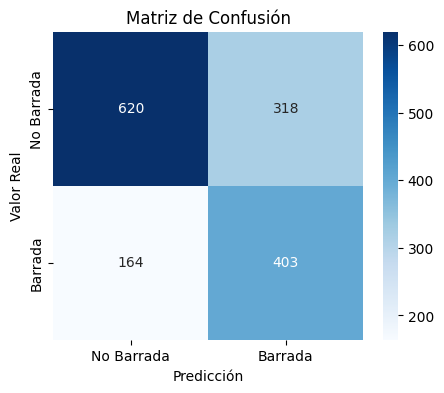

In [131]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Barrada", "Barrada"], yticklabels=["No Barrada", "Barrada"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [132]:
print("Reporte de Clasificación")
print(classification_report(y_test, y_pred, target_names=["No Barrada", "Barrada"]))

Reporte de Clasificación
              precision    recall  f1-score   support

  No Barrada       0.79      0.66      0.72       938
     Barrada       0.56      0.71      0.63       567

    accuracy                           0.68      1505
   macro avg       0.67      0.69      0.67      1505
weighted avg       0.70      0.68      0.68      1505



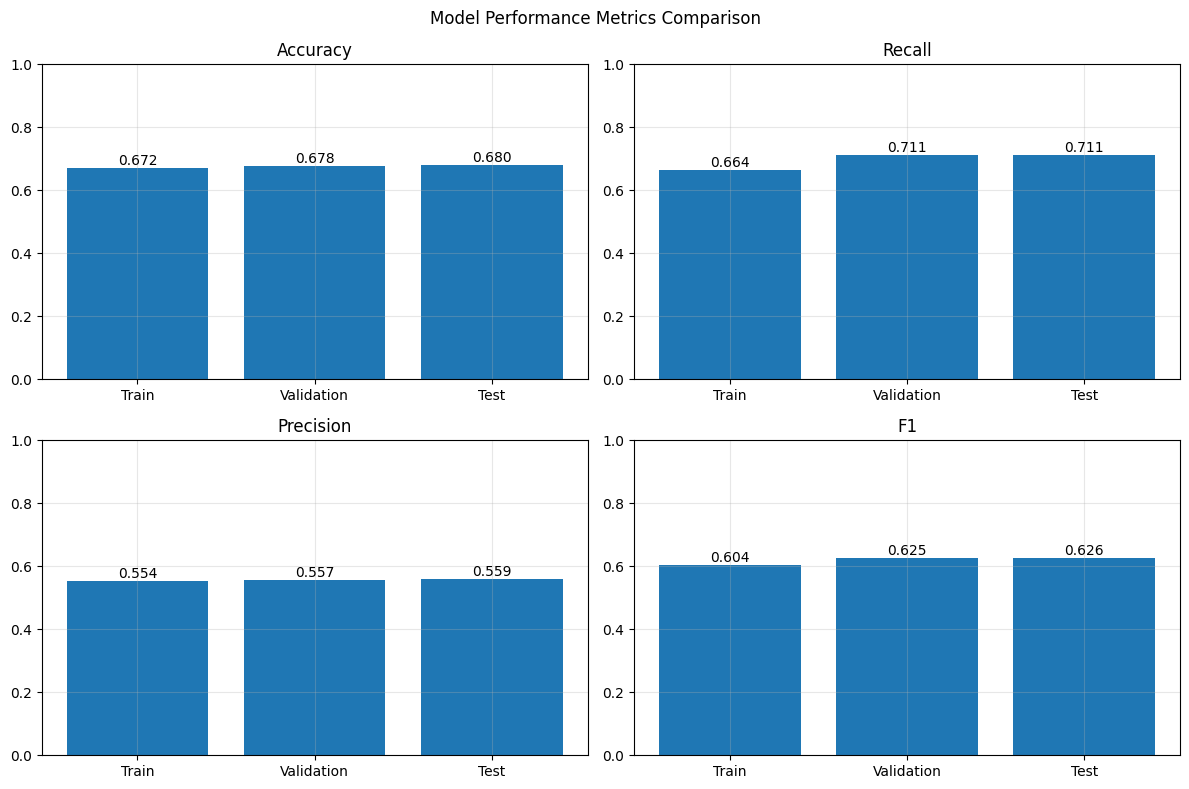

In [133]:
plot_metrics_comparison(efficientnet_train_metrics[-1], efficientnet_valid_metrics[-1], efficientnet_test_metrics)

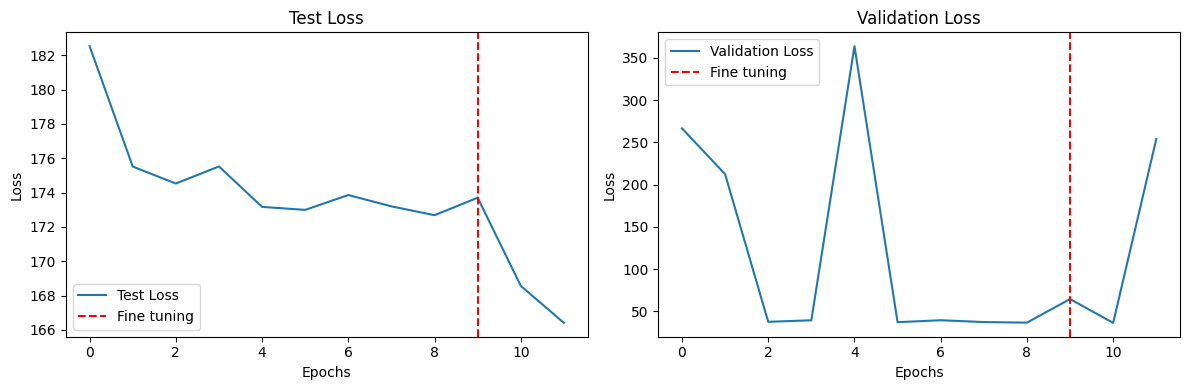

In [134]:
plot_learning_curves(efficientnet_train_metrics, efficientnet_valid_metrics)

## Guardando el modelo

In [135]:
model_path = '/content/drive/MyDrive/datasets/bargal/model_efficientnet.pth'
torch.save(model_efficientnet.state_dict(), model_path)